<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP31_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import sklearn.svm as svm
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv')

df.columns
df = df.drop(columns  = ['Unnamed: 0', 'id'], axis = 1).reset_index(drop = True)

display(df.head())
df.select_dtypes(include = 'object').columns

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,male,27,1.80,87,no,no,always,3,sometimes,no,between 1 and 2 l,no,2 to 4,0 to 2,frequently,walking,overweight_level_i,26.851852
1,male,26,1.85,105,yes,yes,always,3,frequently,no,more than 2 l,no,2 to 4,>5,sometimes,public_transportation,obesity_type_i,30.679328
2,male,41,1.80,99,no,yes,sometimes,3,sometimes,no,between 1 and 2 l,no,2 to 4,3 to 5,frequently,automobile,obesity_type_i,30.555556
3,female,29,1.53,78,no,yes,sometimes,1,sometimes,no,between 1 and 2 l,no,0,0 to 2,no,automobile,obesity_type_i,33.320518
4,female,23,1.65,70,yes,no,sometimes,1,sometimes,no,between 1 and 2 l,no,0,0 to 2,sometimes,public_transportation,overweight_level_i,25.711662


Index(['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

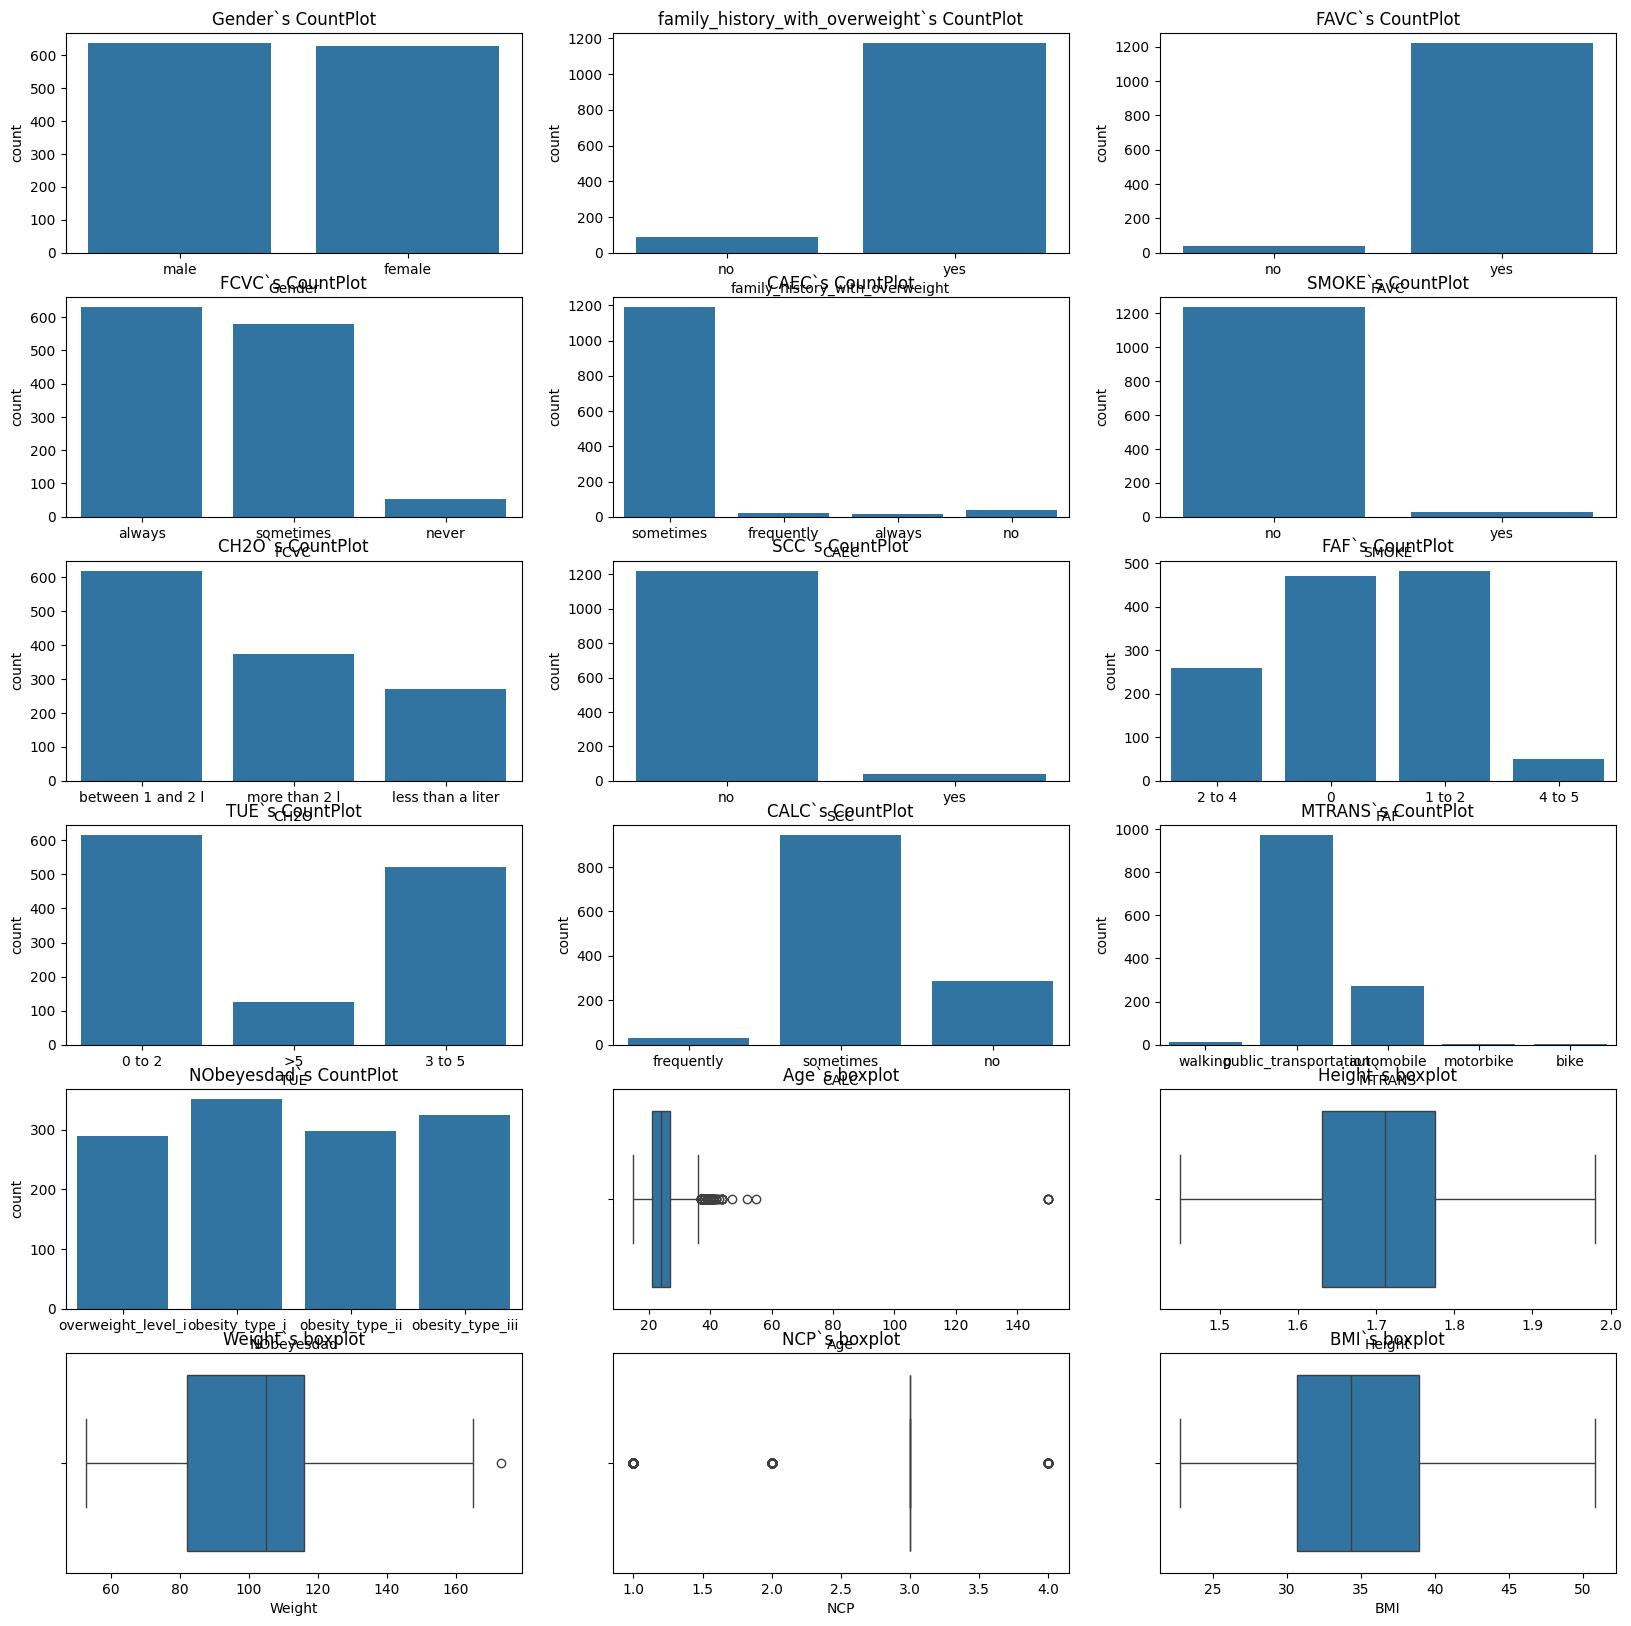

In [3]:
def make_plot(df) :
  plt.figure(figsize = (20,20))
  for i , col in enumerate(df.select_dtypes(include = 'object').columns , start = 1)  :
    plt.subplot(6, 3 ,i)
    sns.countplot(x = df[col])
    plt.title(f"{col}`s CountPlot")
    start_num = i + 1

  for i, col in enumerate(df.select_dtypes(exclude = 'object').columns, start_num) :
    plt.subplot(6,3,i)
    sns.boxplot(x = df[col])
    plt.title(f"{col}`s boxplot")
  plt.show()


make_plot(df)

1-2 데이터 전처리 기법 2가지를 설명하고 주어진 데이터에 적용시 어떤 효과가 있는지 설명하라

표준화
수치형 변수에 대해 각 특성별로 표준점수로 변환하는 데이터 전처리 기법.
이를을 통해 모든 특성이 같은 크기를 가지게 함으로써, 대등하게 비교할 수 있는 스케일을 갖게 한다.

레이블 인코딩
범주형 변수를 코드형 숫자값으로 변환하는 데이터 전처리 기법.
범주형 변수가 많은 경우 원핫인코딩이나 더미코딩 시에는 너무 많은 특징을 갖게되지만 레이블 인코딩 시에는 이러한 문제가 발생하지 않는다

In [4]:
ob_col = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

from sklearn.preprocessing import LabelEncoder

for col in ob_col :
  la = LabelEncoder()
  df[col] = la.fit_transform(df[col])

In [5]:
## Feature Engineering - 파생변수
# 1) 식사횟수 * (고칼로리 + 알콜 섭취)
df['NCP_FAVC_CALC'] = df['NCP'] * (df['FAVC'] + df['CALC'])

# 2) Age * Weight: This could indicate potential risk factors for certain weight-related diseases as age increases.
df['Age_Weight'] = df['Age'] * df['Weight']

# 3 ) NCP * CAEC: This could capture how many meals someone has with how often they snack between meals.
df['NCP_CAEC'] = df['NCP'] * df['CAEC']

# 5 ) FAF * TUE: This could show the potential impact of physical activity in relation to screen time.
df['FAF_TUE'] = df['FAF'] * df['TUE']

2-1 앙상블을 제외한 분류 모델 3가지 구축 및 결과 비교 및 설명

In [6]:
df1 = df.copy()

from sklearn.model_selection import train_test_split
y = df1['NObeyesdad']
X = df.drop('NObeyesdad', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X,y , test_size  = 0.3, random_state = 1234)


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score

lr = LogisticRegression()
dt = DecisionTreeClassifier()
svm = SVC(random_state = 1, probability = True)

models = [lr, dt, svm]

for model in models :
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  p_score = precision_score(y_test, y_pred, average = 'weighted')
  r_score = recall_score(y_test, y_pred, average = 'weighted')
  print(f'{model} :0 {p_score:.2f}, {r_score:.2f}')


LogisticRegression() :0 0.79, 0.79
DecisionTreeClassifier() :0 0.98, 0.98
SVC(probability=True, random_state=1) :0 0.67, 0.63


2-1에서 사용한 모델 중 하나를 골라 그리드 서치를 통해서 파라미터 튜닝 및 분류 모델 성능 평가 (precision ,recall)

In [7]:
## 1. Logistic 의 Grid_Search
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {'C': [0.01, 0.1, 1],
              'solver': ['lbfgs', 'liblinear']}

skf = StratifiedKFold(n_splits = 4)
grid = GridSearchCV(lr, param_grid, cv = skf)
grid.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'liblinear']})

In [8]:
# Best Model 선정
best_model = grid.best_estimator_

# Best Model로 예측 및 평가
y_pred = best_model.predict(x_test)
lr_p_score = precision_score(y_test, y_pred, average = 'weighted')
lr_r_score = recall_score(y_test, y_pred, average = 'weighted')
print(lr_p_score , lr_r_score)

0.9672431228362504 0.9656992084432717


In [9]:
## Decision_Tree의 GridSearch
params = {'max_depth': [1,2,3],
          'min_samples_split': [2,3]}

dt_grid = GridSearchCV(dt, params, cv = 3, refit = True)
dt_grid.fit(x_train, y_train)

# Best Decision Tree 선정
dt_best = dt_grid.best_params_
dt_best_estimators = dt_grid.best_estimator_

pred_y = dt_best_estimators.predict(x_test)
dt_p_score = precision_score(y_test, y_pred, average = 'weighted')
dt_r_score = recall_score(y_test, y_pred, average = 'weighted')

3가지 모델을 soft voting을 이용하여 모델링 한 결과와 2-2과 비교

In [10]:
from sklearn.ensemble import VotingClassifier

models = [('lr' , lr),
           ('dt', dt),
           ('svm', svm)]

for model in models:
  vot = VotingClassifier([model], voting = 'soft')
  vot_model = vot.fit(x_train, y_train)
  vot_pred = vot_model.predict(x_test)
  s_precision = precision_score(y_test, vot_pred, average = 'weighted')
  s_recall = recall_score(y_test, vot_pred, average = 'weighted')

하나의 모델을 선정하여 Drop Column Importance 방식으로 각 변수 별로 전체 컬럼을 포함한 모델과의 recall 값의 차이를 계산하고 시각화

In [11]:
dt_recall = []
for col in X.columns :

  XD = X.drop(columns = col)

  Xtrain, Xtest, ytrain, ytest = train_test_split(XD, y, test_size = 0.3, random_state = 1234)
  dt.fit(Xtrain, ytrain)
  pred = dt.predict(Xtest)
  rec = recall_score(ytest, pred, average = 'macro')
  dt_recall.append(rec)

dict(col_name = X.columns, recall = dt_recall)

{'col_name': Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
        'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
        'CALC', 'MTRANS', 'BMI', 'NCP_FAVC_CALC', 'Age_Weight', 'NCP_CAEC',
        'FAF_TUE'],
       dtype='object'),
 'recall': [0.9869950595757048,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.990119151409474,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694,
  0.984306887532694]}

In [12]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv")
df.head(5)

,ID,키,weight,생년월일,건강검진일,공학여부,채소섭취정도,아침식사여부,일주일운동시간,수면시간,성별
0,ID_4135,169.01,65.47,20041003,2020_11_15,1,2,1,4.4,8.3,남성
1,ID_3289,181.62,69.36,19970725,2014_11_20,0,3,0,4.4,6.9,남성
2,ID_1847,160.89,65.12,20020921,2020_01_28,1,1,1,1.7,9.6,여성
3,ID_4785,162.21,62.28,20020106,2018_09_27,1,4,0,5.1,6.8,남성
4,ID_5693,159.13,54.11,19980708,2015_03_03,0,4,1,0.3,8.5,여성


In [13]:
## 년도 생성
df['생년월일'] = pd.to_datetime(df['생년월일'].astype(str))
df['건강검진일'] = pd.to_datetime(df['건강검진일'].str.replace('_','-'))

## 차이
df['diff'] = (df['건강검진일'] - df['생년월일'])
df['만나이'] = df['diff']//365


In [14]:
df['만나이'] = df['만나이'].astype(str).str.split(' ').str[0] + '세'

In [15]:
df['bmi'] = df['weight'] / (df['키'] / 100) ** 2

적정 체중 여부 (BMI가 아래 구간에 들어올 경우) </br>
17세 남자 : 21.03이상 23.21 미만 </br>
17세 여자 : 20.03이상 22.39 미만 </br>
16세 남자 : 21.18이상 23.45 미만 </br>
16세 여자 : 19.61이상 21.74 미만 </br>

In [16]:
map = {
    ('17세','남성') : (21.03, 23.21),
    ('17세','여성') : (20.03, 22.39),
    ('16세','남성') : (21.18, 23.45) ,
    ('16세','여성') : (19.61, 21.74)
}


def is_normal_weight(age, gender, bmi):
    lower, upper = map[(age, gender)]
    return lower <= bmi < upper

df['적정체중여부'] = [is_normal_weight(df['만나이'][i], df['성별'][i], df['bmi'][i]) for i in range(len(df))]
df['적정체중여부'] = df['적정체중여부'].astype(int)

pd.crosstab(pd.cut(df['bmi'], bins = 5), df['적정체중여부'], margins = True)

적정체중여부,0,1,All
bmi,,,
"(16.08, 18.776]",325,0,325
"(18.776, 21.459]",1074,1989,3063
"(21.459, 24.141]",942,2004,2946
"(24.141, 26.823]",451,0,451
"(26.823, 29.506]",16,0,16
All,2808,3993,6801


In [17]:
df1 = df.drop(['ID','diff'] , axis = 1)

for col in df1.select_dtypes(include = ['int64', 'object']).columns :
  print(df[col].value_counts())

공학여부
1    3429
0    3372
Name: count, dtype: int64
채소섭취정도
2    1406
4    1384
3    1377
1    1339
0    1295
Name: count, dtype: int64
아침식사여부
0    3433
1    3368
Name: count, dtype: int64
성별
여성    3845
남성    2956
Name: count, dtype: int64
만나이
17세    3686
16세    3115
Name: count, dtype: int64
적정체중여부
1    3993
0    2808
Name: count, dtype: int64


4-1에서 구한 적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인

In [26]:
# 공학여부 : 1,0
# 아침식사 여부 : 1, 0
# 성별
# 채소섭취정도 : 0,1,2,3,4
# 수면시간, 운동시간

cols = ['공학여부', '아침식사여부', '일주일운동시간', '채소섭취정도', '수면시간', '성별']

lst = []
for col in cols:
  cross = pd.crosstab(df[col], df['적정체중여부'])
  stat, p_val, dof, exp = stats.chi2_contingency(cross)
  lst.append({'name': col, 'p_value': p_val})

col_df = pd.DataFrame(lst)
col_df['check'] = col_df['p_value'].map(lambda x : '유의' if x < 0.05 else '유의X')
col_df

,name,p_value,check
0,공학여부,0.033066,유의
1,아침식사여부,0.696488,유의X
2,일주일운동시간,0.119871,유의X
3,채소섭취정도,0.038083,유의
4,수면시간,0.554877,유의X
5,성별,0.961379,유의X


4-2에서 유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석을 하라 (로지스틱회귀 ,xgb)

In [36]:
x = df1[['공학여부','채소섭취정도']]
y = df1['적정체중여부']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3 , random_state = 1234)

def model_eval(model, x_train, x_test, y_train, y_test) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  acc = accuracy_score(y_test, pred)
  pre = precision_score(y_test, pred)
  rec = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc = roc_auc_score(y_test, pred, average = 'macro')
  print(acc, pre, rec, f1, roc)

lr = LogisticRegression()
xc = XGBClassifier()

model_eval(lr, x_train, x_test, y_train, y_test)
model_eval(xc, x_train, x_test, y_train, y_test)



0.6036256736893679 0.6036256736893679 1.0 0.7528261533761075 0.5
0.6036256736893679 0.6036256736893679 1.0 0.7528261533761075 0.5


 두 모델의 roc-auc 그래프를 하나의 그래프에 겹쳐 그려라

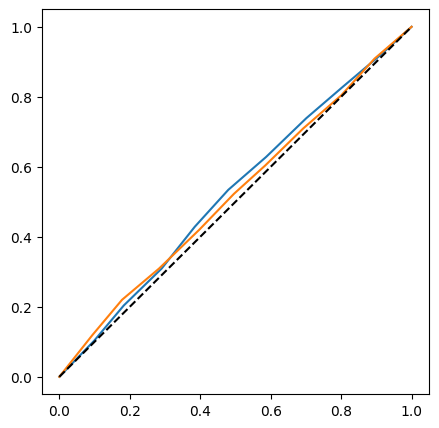

In [45]:
lr_proba = lr.predict_proba(x_test)[:,1]
xc_proba = xc.predict_proba(x_test)[:,1]

fpr_lr , tpr_lr , tresholds = roc_curve(y_test, lr_proba)
fpr_xc , tpr_xc , tresholds = roc_curve(y_test, xc_proba)

fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.plot(fpr_lr, tpr_lr, label = 'logistic')
ax.plot(fpr_xc , tpr_xc , label = 'xgb')
ax.plot([0,1], [0,1], 'k--', label = 'Random')

5. 평균이 θ
이고 분산이 100인 정규분포의 사전분포가 100, 256일때 120의 값을 가지는 데이터가 있을 경우 사후평균은? (5점)
무게가 N(θ
, 100)인 정규분포에서, 사전분포는 N(100, 256)이다. 제품의 무게가 120kg일 때, 사후분포의 평균

In [46]:
var = 100

mu = 100
var_p = 256

x = 120
N = 1

denom = N * var_p + var
mu = (var*100 + N * var_p * x) / denom
print(mu)

114.38202247191012


회귀 모델링 후 유의하지 않는변수 파악

In [57]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv')
display(df.head(4))

import statsmodels.api as sm

X = sm.add_constant(df[['TV', 'Radio','Newspaper']])
y = df['Sales']

model = sm.OLS(y, X).fit()
print(model.summary())

p_val = model.pvalues
col_name = p_val.index

pd.DataFrame({'col_name': col_name, 'p_value' : p_val})

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           8.13e-99
Time:                        12:26:21   Log-Likelihood:                -383.34
No. Observations:                 200   AIC:                             774.7
Df Residuals:                     196   BIC:                             787.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6251      0.308     15.041      0.0

,col_name,p_value
const,const,1.682677e-34
TV,TV,1.892945e-95
Radio,Radio,4.602097e-27
Newspaper,Newspaper,9.538145e-01


VIF 통한 다중 공선성 진단

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF_Column  = X.columns

pd.DataFrame([VIF_Column, VIF]).T

,0,1
0,const,6.8489
1,TV,1.004611
2,Radio,1.144952
3,Newspaper,1.145187


데이터 설명 : A,B,C,D,E 영업사원의 각 계약 성사 유무 (1:계약 , 0:미계약) 를 나타낸 데이터이다. 영업사원의 평균 계약 성사 건수는 같은지 통계 검정하라

In [68]:
from statsmodels.stats.contingency_tables import cochrans_q
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv")

cc_df = df.drop('Unnamed: 0', axis = 1)
ccq = cochrans_q(cc_df)
print(ccq.statistic)
print(ccq.pvalue)

4.516129032258065
0.3406392758219471


In [75]:
from scipy.stats import poisson
## 유기견이 하루에 2.2마리 발생한다

# 한 마리도 안 버려질 확률
lamb = 2.2
print(poisson.cdf(mu = lamb, k = 0))

# 적어도 2마리 버려질 확률
1 - (poisson.pmf(0, 2.2) + poisson.pmf(1, 2.2))

0.11080315836233386


0.6454298932405316